## Import, I/O and preprocessing 部分

In [1]:
!pip install /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl
!mkdir /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Processing /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl


首先，我们观察 `train.csv` 和 `greeks.csv` 的元素组成:

In [2]:
import numpy as np 
import pandas as pd 
import os
import xgboost
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import category_encoders as ce
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import plot_tree
from xgboost import plot_importance

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE

# "taqaddum" 的缩写，阿拉伯语中意为“进展”，用于在循环中显示进度条。
from tqdm.notebook import tqdm

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
        
train_dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
meta_dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
sample_submission_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
test_dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

print("\n训练集概貌如下:")
print(train_dataset_df.head())
print("\n完整训练集的尺寸是 {}。".format(train_dataset_df.shape))

print("\n训练集的元数据概貌如下:")
print(meta_dataset_df.head())
print("\n完整训练集元数据的尺寸是 {}。".format(meta_dataset_df.shape))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



训练集概貌如下:
             Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.6110

In [3]:
train_dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


数据集：58 列，其中 1 列为 ID（没有用处），一列的病与否（0/1），feature 为 56。

不难发现两类数据比例严重不均衡。

<Axes: ylabel='Class'>

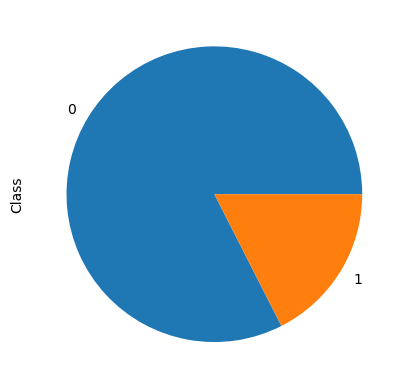

In [4]:
plot_df = train_dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

做了一下每一个特征的数值分布，发现有大量极端值。代码在此从略，可以在较早的 Version 中找到。

---

## 辅助函数编写部分

#### 缺省值检查与处理
接下来，我们先简单装配一个简单的 NaN 处理。

In [5]:
column_names = list(train_dataset_df.columns.values)

# 看一看每个特征都有多少空出来的。
def check_nan(dataset: pd.DataFrame, column_names):
    for column in column_names:
        if dataset[column].isnull().sum() != 0:
            print("column: {0} --> {1}".format(column, dataset[column].isnull().sum()))
        
check_nan(train_dataset_df, column_names)

column: BQ --> 60
column: CB --> 2
column: CC --> 3
column: DU --> 1
column: EL --> 60
column: FC --> 1
column: FL --> 1
column: FS --> 2
column: GL --> 1


In [6]:
# 根据特征分析，不应使用平均数（有极大之值）和众数（小数点）。
def fill_nan(dataset: pd.DataFrame, column_names):
    new_dataset = copy.deepcopy(dataset)
    
    for column in column_names:
        if dataset[column].isnull().sum() != 0:
            median = dataset[column].median()
            new_dataset[column].fillna(median, inplace = True)
            
    return new_dataset

---

#### balanced cross entropy 函数

cross-entropy 函数。参考 [这里](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442)。

In [7]:
def balanced_log_loss(y_true: np.ndarray, y_pred: np.ndarray):
    
    # y_true: 正确的标签，一个数组。
    # y_pred: 预测的概率数组，每一个值代表该位置有多大可能为有病（1），即 p_1。

    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    
    # 权重计算。
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    
    # 将数组 y_pred 中的元素限制在一个接近 0 和 1 的范围内，避免概率值太极端导致计算问题。
    # 在机器学习中，通常会对概率进行截断处理，以确保数值的稳定性和避免数值计算的错误。
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    
    # 交叉熵损失。
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    
    # 加权计算损失。
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    
    # 返回平均损失。
    return balanced_log_loss/(N_0+N_1)

---

## 数据准备与模型训练部分

#### 类别特征编码

"EJ" 列不是数值，因此我们将他们编码为 int 类型。这一步必须要在传入模型之前完成。

In [8]:
# 获取所有预测列。
predictor_columns = [n for n in train_dataset_df.columns if n != 'Class' and n != 'Id']

first_category = train_dataset_df.EJ.unique()[0] # first_category = 'B'
train_dataset_df.EJ = train_dataset_df.EJ.eq(first_category).astype('int') # True = 1, False = 0
# counter = Counter(dataset_df.EJ) 509 108

first_category = train_dataset_df.EJ.unique()[0]
test_dataset_df.EJ = test_dataset_df.EJ.eq(first_category).astype('int') # True = 1, False = 0
test_predictors = test_dataset_df[predictor_columns] # 去掉 id。

---

#### 欠采样数据生成

参考的方法中使用了 trival 的 oversample 方法，在这里我们使用 `BorderlineSMOTE`。
- 我们在对于 metadata 数据的处理上，没有使用 `times` 这一项。这一维在数据上理应与疾病无关。

In [9]:
# 数据分布不平衡，需要欠采样器。
ros = BorderlineSMOTE(random_state=42)

train_dataset_nonan = fill_nan(train_dataset_df, column_names)
train_dataset_nonanid = train_dataset_nonan.drop(['Id'], axis=1)

# 重采样。
# meta_dataset_df.Alpha 是类别标签，用作欠采样时候应当生成的类别。y_ros 是 B A D G
train_ros, y_ros = ros.fit_resample(train_dataset_nonanid, meta_dataset_df.Alpha)

x_ros = train_ros.drop(['Class'], axis=1)

# y_.value_counts()/y_.shape[0]
# y_ 是 0 和 1。
y_ = train_ros.Class

In [10]:
class Ensemble():
    
    # 初始化函数。
    def __init__(self):
        
        # 缺省值填充。
        self.imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        
        # 分类器列表。这里也是个调参大头。
        self.classifiers = [xgboost.XGBClassifier(tree_method='gpu_hist', n_estimators=100,max_depth=3,learning_rate=0.15,subsample=0.9,colsample_bytree=0.85),
                           
                           # 在集成模型中使用 N_ensemble_configurations 种不同的配置来构建多个子模型，然后将它们组合起来形成最终的分类器。
                           TabPFNClassifier(device='cuda', N_ensemble_configurations=24),
                          
                           TabPFNClassifier(device='cuda', N_ensemble_configurations=64),
                            
                           TabPFNClassifier(device='cuda', N_ensemble_configurations=128),
                            
                           RandomForestClassifier(criterion='entropy', max_depth= None, min_samples_leaf= 1, min_samples_split= 4,n_estimators= 200)
                           ]
        
    
    # 模型拟合。注意，这里输入的 y 是 y_meta。
    def fit(self,X,y):
        
        # pd.Series -> np.Ndarray
        y = y.values
        
        # [A, B, ..., G, B] -> [0, 1, ..., 3, 2]
        unique_classes, y = np.unique(y, return_inverse=True)
        
        # self.classes_: ['A', 'B', 'D', 'G']
        self.classes_ = unique_classes
        
        # 祖宗之法不可变...
        first_category = X.EJ.unique()[0]
        X.EJ = X.EJ.eq(first_category).astype('int')
        X = self.imputer.fit_transform(X)

        for classifier in self.classifiers:
            if classifier==self.classifiers[1] or classifier==self.classifiers[2] or classifier==self.classifiers[3]:
                classifier.fit(X, y, overwrite_warning =True) # 不这样写 TabPFNClassifier 会报错。
            else :
                classifier.fit(X, y)
    
    # 模型预测。
    def predict_proba(self, x):
        
        # 祖宗之法不可变...
        x = self.imputer.transform(x)
        
        # probabilities 的形状为 (m, n, k)，其中 m 是分类器的个数， n 是样本个数，k 是类别的个数。
        probabilities = np.stack([classifier.predict_proba(x) for classifier in self.classifiers])
        
        # 形状为 (n, k)，表示每个样本属于每个类别的平均概率。
        averaged_probabilities = np.mean(probabilities, axis=0)
        
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        
        # 看着挺复杂，其实就是个归一化。保证概率和为 1。
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1) 

In [11]:
def training(model, x, y, y_meta):
    
    outer_results = list()
    outer_accuracy = list()
    best_loss = np.inf
    split = 0
    models=[]
    
    for train_idx,val_idx in tqdm(cross_val.split(x), total = SPLITS):
        
        split+=1
        x_train, x_val = x.iloc[train_idx],x.iloc[val_idx]
        y_train, y_val = y_meta.iloc[train_idx], y.iloc[val_idx]
             
        model.fit(x_train, y_train)
        models.append(model)
        
        # y_pred: [n,4]; probabilities: [n, 2]
        y_pred = model.predict_proba(x_val)
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        
        # 量化计算损失。
        p0 = probabilities[:,:1]
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((y_pred.shape[0],))
        for i in range(y_pred.shape[0]):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        y_p = y_p.astype(int)
        loss = balanced_log_loss(y_val,y_p)
        diff_count = np.count_nonzero(y_val != y_p)
        accuracy = (y_p.size - diff_count) / y_p.size

        if loss<best_loss:
            best_model = model
            best_loss = loss
            best_accuracy = accuracy
            print('best_model_saved')
        
        outer_results.append(loss)
        outer_accuracy.append(accuracy)
        
        print('>val_loss=%.5f, split = %.1f' % (loss,split))
        print('accuracy=', str(accuracy))
        
    print('LOSS: %.5f' % (np.mean(outer_results)))
    print('ACCURACY: %.5f' % (np.mean(outer_accuracy)))

    return best_model, models

---

#### 模型训练

我们取折数为 5。

In [12]:
SPLITS = 5
cross_val = KFold(n_splits = SPLITS, shuffle=True, random_state=42)

model_type = Ensemble()
best_model, models = training(model_type, x_ros, y_, y_ros)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_23/3186108374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


best_model_saved
>val_loss=0.00000, split = 1.0
accuracy= 1.0


/tmp/ipykernel_23/3186108374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.13761, split = 2.0
accuracy= 0.9926289926289926


/tmp/ipykernel_23/3186108374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.27773, split = 3.0
accuracy= 0.9852579852579852


/tmp/ipykernel_23/3186108374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.15012, split = 4.0
accuracy= 0.9901719901719902


/tmp/ipykernel_23/3186108374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.21518, split = 5.0
accuracy= 0.9852579852579852
LOSS: 0.15613
ACCURACY: 0.99066


---

## 预测与提交部分
#### 预测结果

In [13]:
y_pred = best_model.predict_proba(test_predictors)

# 将 [B G D] 三类的概率加在一起，算作疾病类别。 5x4 -> 5x2
probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], axis=1, keepdims=True)), axis=1)

p0 = probabilities[:,:1]
p0[p0 > 0.60] = 1
p0[p0 < 0.25] = 0

---

#### 生成 .csv 文件

In [14]:
submission = pd.DataFrame(test_dataset_df["Id"], columns=["Id"])

# 创建一个名为 class_0 的新列，并将 p0 的值赋给这一列。
submission["class_0"] = p0
submission["class_1"] = 1 - p0

# index = False 表示不将行索引保存在 csv 文件中。
submission.to_csv('submission.csv', index=False)